<a href="https://colab.research.google.com/github/cbernet/introduction_machine_learning/blob/master/notebooks/deep_learning_intro/keras_tensorflow_handwritten_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparing the dataset 

The full MNIST handwritten digits dataset can easily be downloaded and loaded in memory with scikit-learn: 

In [42]:
from sklearn.datasets import fetch_openml
images, labels = fetch_openml('mnist_784', version=1, return_X_y=True)

Then, we print basic information about the dataset: 

In [43]:
import numpy as np
print(images.shape)
print(np.max(images))
print(np.unique(labels))

(70000, 784)
255.0
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


We see that we have 70 000 digit examples. Each image has 28x28=784 pixels, flattened into a 1D array. There is a single color channel for each pixel, so these are grayscale images. The maximum grayscale level is 255. 

Neural networks prefer to deal with numbers close to unity, so we need to normalize our grayscale levels:

In [44]:
images = images / 255. 
np.max(images)

1.0


The label provides the ground truth for each image, and is stored as a string. 

Neural networks deal with numbers, not strings. So let's convert the labels to integers: 

In [45]:
labels = labels.astype(int)
labels

array([5, 0, 4, ..., 4, 5, 6])

Given an image, the network will produce 10 values from its output neurons. They are the estimated probabilities for the image to belong to each category. 

During the training, these 10 values will need to be compared to the target (currently a single label between 0 and 9), and the network parameters will be adapted so that later on, the network predictions are brought closer to the target. 

But how can we compare a vector of 10 values with a single label value? 

The solution is to translate each label to a vector of length 10 with a technique called *one-hot encoding*: 

* label `0` is translated to `[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]`
* label `1` is translated to `[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]`
* ...
* label `9` is translated to `[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]`

After doing that, the values from the output neurons, which are probabilities ranging from 0 to 1, can be compared directly to the values in the target vector. In this way, for a given number, say 0, the neural network will be trained to output a high probability from the first output neuron, and a low probability from the following neurons.  

One-hot encoding can be performed easily with the utilities provided by Keras: 

In [46]:
import tensorflow as tf
targets = tf.keras.utils.to_categorical(labels,10)
np.set_printoptions(edgeitems=5)
print(labels)
print(targets)
np.set_printoptions(edgeitems=3)


[5 0 4 1 9 ... 2 3 4 5 6]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 ...
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


Finally, we split our data into a training sample and a testing sample:

In [47]:
test_size=5000
x_test = images[:test_size]
y_test = targets[:test_size]
x_train = images[test_size:]
y_train = targets[test_size:]

The first 5000 images and labels are going to be used later to test the performance of our network, and the remaining images will be used for training. 

## Simple dense neural network with Keras

As a first step, just to get familiar with the Keras interface, we will train a simple dense neural network to identify our digits. 

In machine learning, it's always good to start with a simple model, and to gradually make it more complex only if necessary. 

So we'll start with a super simple network with: 

* layer 1: input layer with 784 nodes 
* layer 2: dense layer with 3 neurons, with ReLU activation (yes, only three!)
* layer 3: dense layer with 10 neurons, with softmax activation. 

The neurons of layers 2 and 3 are fully connected to the neurons of the previous layer. So there is a high density of connections before these layers, and that is why they are called dense layers. A neural network with dense layers is called a dense network.

Keras offers two ways to define neural networks: the sequential API and the functional API. Generally speaking, the sequential API allows for more compact and readable code, and the functional API for more flexible networks. 

### Sequential API

In [48]:
from tensorflow.keras import layers, models, optimizers

model = models.Sequential([
    layers.Dense(3, input_shape=(images.shape[1],), activation='relu'), 
    layers.Dense(10, activation='softmax'),     
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 3)                 2355      
_________________________________________________________________
dense_16 (Dense)             (None, 10)                40        
Total params: 2,395
Trainable params: 2,395
Non-trainable params: 0
_________________________________________________________________


We see that the first layer has 2355 parameters. Why? 

Remember that we have 784 input values, and 3 neurons on this layer. The weighted input for neuron $j$ is: 

$$z_j = \sum_{i=1}^{784} w_{ij} x_i + b_j$$

where $w_{ij}$ is the weight of the link carrying value $x_i$ to neuron $j$, and $b_j$ is the bias of neuron $j$. So we get 785 parameters for each of the 3 neurons, and 3x785=2355 parameters in total.

---

**Exercise:**

* In the same way, calculate the number of parameters of the final layer. 

---

As you can see, this small neural network has 2395 parameters that will be optimized during the training. This already offers quite a bit of flexibility. 

### Functional API

With the functional API, the same network would be defined in this way: 

In [49]:
inputs = layers.Input(shape=(images.shape[1],))
out_1 = layers.Dense(3, activation='relu')(inputs)
predictions = layers.Dense(10, activation='softmax')(out_1)
model = models.Model(inputs, predictions)
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 2355      
_________________________________________________________________
dense_18 (Dense)             (None, 10)                40        
Total params: 2,395
Trainable params: 2,395
Non-trainable params: 0
_________________________________________________________________


In this case, `inputs`, `out_1`, and `predictions` are tensors. Or rather, since we are only defining the structure of the network, "symbolic" tensors. 

When the network is evaluated for a given image, actual tensors will flow through the network. 

Therefore, a layer can be seen as a function: it takes an input tensor and provides an output tensor. This is what is represented by the functional API.

### Training

Now that our neural network is defined, we need to compile it so that it can be trained and used. 

We specify that we want to use [Adam](https://arxiv.org/abs/1412.6980) as optimization method. 

We also request to compute the accuracy of the model during training and testing. 

In [12]:
# define how the neural network will learn, 
# and compile the model. 
# models must be compiled before 
# they can be trained and used. 
# the loss, optimizer, and metrics arguments 
# will be covered in a future post. 
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(), 
              metrics=['accuracy'])


After compilation, we can train the network:

In [13]:
history = model.fit(x=x_train, y=y_train, validation_data=(x_test,y_test),
                    batch_size=100, epochs=10)

Epoch 1/10
650/650 [==============================] - 2s 3ms/step - loss: 1.5632 - accuracy: 0.4524 - val_loss: 1.1737 - val_accuracy: 0.6452
Epoch 2/10
650/650 [==============================] - 2s 3ms/step - loss: 1.0478 - accuracy: 0.6872 - val_loss: 0.9432 - val_accuracy: 0.7196
Epoch 3/10
650/650 [==============================] - 2s 3ms/step - loss: 0.9192 - accuracy: 0.7234 - val_loss: 0.8646 - val_accuracy: 0.7472
Epoch 4/10
650/650 [==============================] - 2s 3ms/step - loss: 0.8622 - accuracy: 0.7406 - val_loss: 0.8210 - val_accuracy: 0.7550
Epoch 5/10
650/650 [==============================] - 2s 3ms/step - loss: 0.8283 - accuracy: 0.7495 - val_loss: 0.7995 - val_accuracy: 0.7638
Epoch 6/10
650/650 [==============================] - 2s 3ms/step - loss: 0.8066 - accuracy: 0.7542 - val_loss: 0.7816 - val_accuracy: 0.7638
Epoch 7/10
650/650 [==============================] - 2s 3ms/step - loss: 0.7905 - accuracy: 0.7575 - val_loss: 0.7653 - val_accuracy: 0.7722
Epoch 

We see that the network learns fast, and actually, the performance is already quite good, even with only 3 neurons on the hidden layer! 

---

**Exercise**

Actually, with such a low number of tunable parameters, the optimization can easily get stuck in local minima, and this depends on the random initialization of the network parameters before training. 

* Re-run the training several times, and see how the maximum accuracy varies. 

**Note that you need to re-create the model and re-compile it if you want to redo the training. Otherwise the network will start from its state at the end of the previous training.**

---

### Evaluation and performance metrics

Now that our network is trained, we can evaluate it for all images in the test sample:

In [14]:
predictions = model.predict(x_test)
predictions.shape

(5000, 10)

And we can write a small function to display the results of the evaluation for a set of images:

In [15]:
import matplotlib.pyplot as plt

def plot_images(indices, predictions): 
    if len(indices)>6:
        print('please provide at most 6 indices')
        return
    fig = plt.figure(dpi=100)
    for i, index in enumerate(indices):
        fig.add_subplot(2, 3, i+1)
        # our input images are flattened. 
        # restoring the pixel structure
        # before display.
        img = x_test[index].reshape(28,28)
        plt.imshow(img)
        # looking for slot with highest probability
        # in the one-hot encoded array:
        true_cat = np.argmax(y_test[index])
        pred_cat = np.argmax(predictions[index])
        plt.title('true:{}, pred:{}'.format(true_cat, pred_cat))
        plt.axis('off')

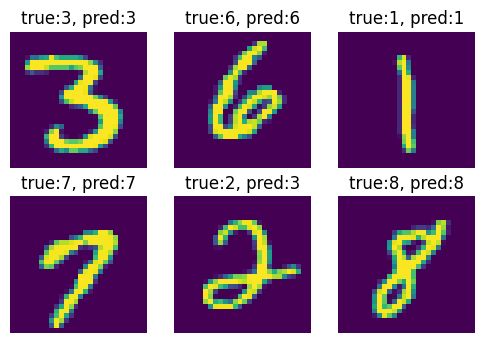

In [18]:
plot_images(np.arange(6)+12, predictions)

---

**Exercise:**

* look at more images (just add an integer to `np.arange(6)` to look at another range of indices).

---

You might have noticed that the fit method of the Keras model returns a history object, and that we kept track of it. This object contains a `history` dictionary: 

In [19]:
history.history

{'accuracy': [0.452353835105896,
  0.6871538758277893,
  0.7234307527542114,
  0.7405846118927002,
  0.7494922876358032,
  0.7541846036911011,
  0.7575230598449707,
  0.7605999708175659,
  0.7642307877540588,
  0.7660461664199829],
 'loss': [1.5632402896881104,
  1.0478119850158691,
  0.919158935546875,
  0.8622262477874756,
  0.8283411264419556,
  0.8066073656082153,
  0.7905269861221313,
  0.7782993912696838,
  0.7694495916366577,
  0.7614462375640869],
 'val_accuracy': [0.6452000141143799,
  0.7196000218391418,
  0.7472000122070312,
  0.7549999952316284,
  0.7638000249862671,
  0.7638000249862671,
  0.7721999883651733,
  0.7748000025749207,
  0.7771999835968018,
  0.7775999903678894],
 'val_loss': [1.1736708879470825,
  0.9431796073913574,
  0.8645637631416321,
  0.8210230469703674,
  0.7994813323020935,
  0.781579852104187,
  0.765319287776947,
  0.7558761239051819,
  0.748784065246582,
  0.7455596923828125]}

We see that this dictionary contains loss and the accuracy as a function of the epoch, for both the training and validation (test) samples. To plot them, do: 

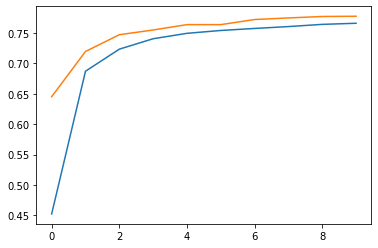

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

And we can write a function to plot the history, as we will need it several times later on: 

In [21]:
def plot_history(history, miny=None):
    hd = history.history
    fig = plt.figure(figsize=(10,5))
    fig.add_subplot(1, 2, 1)
    plt.plot(hd['accuracy'])
    plt.plot(hd['val_accuracy'])
    if miny: 
        plt.ylim(miny, 1.0)
    plt.title('accuracy')
    plt.grid()
    fig.add_subplot(1, 2, 2)
    plt.plot(hd['loss'], label='train')
    plt.plot(hd['val_loss'], label='test')
    plt.title('loss')
    plt.legend()
    plt.grid()

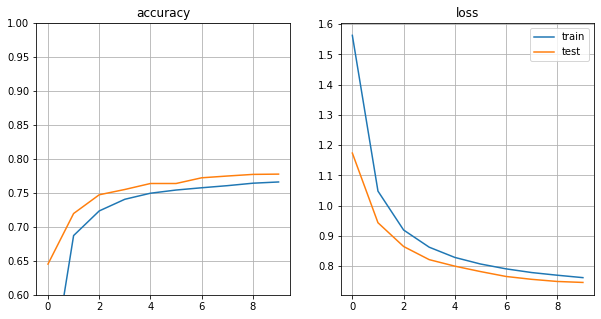

In [22]:
plot_history(history, miny=0.6)

We'll see how to tune the network for better performance later on. But for now, let's have a more detailed look at our trained model. 

### Internal representation and embedding

Here is again a summary of our model: 

In [ ]:
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_150 (Dense)            (None, 3)                 2355      
_________________________________________________________________
dense_151 (Dense)            (None, 10)                40        
Total params: 2,395
Trainable params: 2,395
Non-trainable params: 0
_________________________________________________________________


Let's take a moment to really understand what happens when an image goes through the network. 

The image has 784 pixels, so the image is defined by 784 variables, which are the gray levels in the pixels. In other words, each image corresponds to a point in a space with 784 dimensions. 

The first hidden layer, the one with three neurons, has three output values. 

So what this layer is doing is to project the image from the original 784D space to 3D space. When you think about it, that's not an obvious task. The three coordinates of the image in the 3D space constitute an intermediate **representation**. 

Finally, the 3D space is partitioned with 10 planes in an attempt to separate the 10 digit categories. 

When we train the network, it learns how to do the 784D to 3D projection in such a way as to make the linear separation possible in the last layer of the network. 

Now why did I choose to put only three neurons in the hidden layer? because it's always good to start simple in machine learning as I've already said, and also because we can now visualize the intermediate 3D representation. With more dimensions, it would have been more difficult to display the representation, but not impossible. We'll come back to that.  

Let's display the 3D representation. For this, we need to create a function which takes a bunch of images and returns the output of the hidden layer: 

In [23]:
from tensorflow.keras import backend as K
# create the function:
hidden_repr = K.function(
    [model.layers[0].input], 
    # -2 : next-to-last layer
    [model.layers[-2].output]
)
# compute the 3D representation for all images: 
embedding = hidden_repr([images])[0]
embedding.shape

(70000, 3)

We have 70 000 points. Trying to display them would kill your browser, so we are going to select only 2000 points: 

In [24]:
nsmall = 2000
small = embedding[:nsmall]
slabels = labels[:nsmall]

And finally we make the plot:

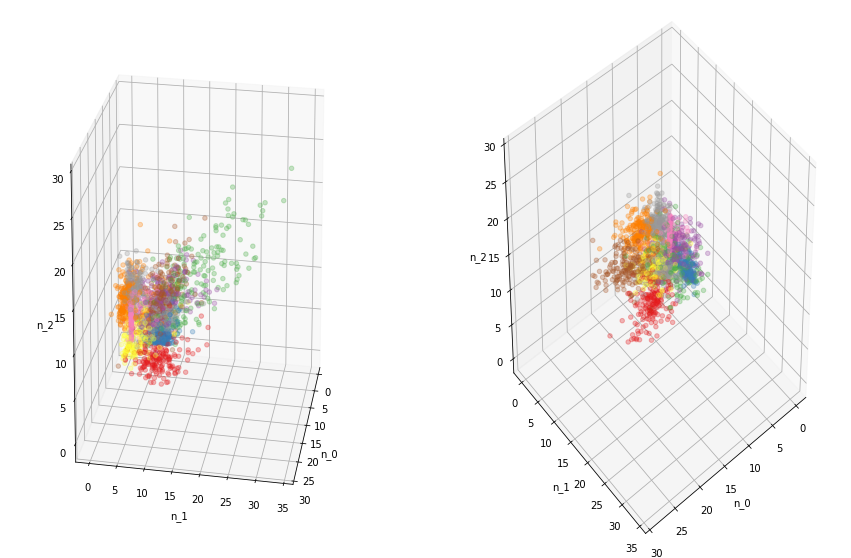

In [31]:
import mpl_toolkits.mplot3d.axes3d

def plot_3d():
    ax.scatter(small[:,0], small[:,1], small[:,2], c=slabels, cmap='Set1', alpha=0.3)
    ax.set_xlabel('n_0')
    ax.set_ylabel('n_1')
    ax.set_zlabel('n_2')

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(121, projection='3d')
plot_3d()
ax.view_init(20,10)
ax = fig.add_subplot(122, projection='3d')
plot_3d()
ax.view_init(40,50)

The network distributes the points so that the last layer is able to separate the classes by running planes through the 3D space.

In some trainings, we might see that some of the images end up with a vanishing value for some of the neurons. These images do not activate the corresponding ReLUs. 

If a single neuron does not fire, the point ends up on one of the three planes $n_1=0$, $n_2=0$ or $n_3=0$. If two neurons did not fire, the point ends up on either the $n_1$, $n_2$, or $n_3$ axis. 

### Exercises: hyperparameter tuning

* Try and increase the batch size to 500. What do you conclude? 
* Try and set the learning rate of the optimizer to 0.03. What do you conclude? 
* Make the network more complex by adding neurons on the hidden layer, and then by adding a second dense hidden layer.
  * In all cases check the performance and control overfitting with the plot_history function
  * What maximum test accuracy can you reach? 
  
Here is what I have:

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
130/130 [==============================] - 1s 5ms/step - loss: 0.5786 - accuracy: 0.8455 - val_loss: 0.2768 - val_accuracy: 0.9234
Epoch 2/15
130/130 [==============================] - 1s 4ms/step - loss: 0.2554 - accuracy: 0.9297 - val_loss: 0.2152 - val_accuracy: 0.9410
Epoch 3/15
130/130 [==============================] - 0s 4ms/step - loss: 0.2024 - accuracy: 0.9435 - val_loss: 0.1744 - val_accuracy: 0.9522
Epoch 4/15
130/130 [==============================] - 0s 4ms/step - loss: 0.1684 - acc

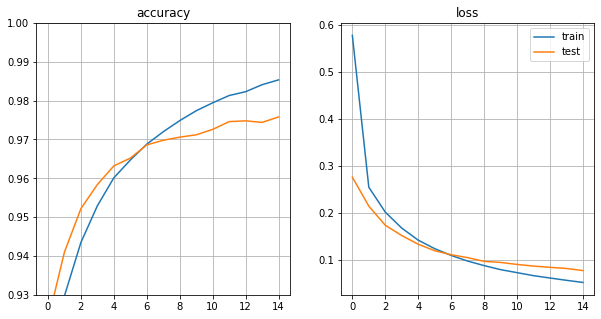

In [26]:
from tensorflow.keras import layers, models, optimizers

model = models.Sequential([
    layers.Dense(100, input_shape=(images.shape[1],), activation='relu'), 
    layers.Dense(10, activation='softmax'),     
])

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(), 
              metrics=['accuracy'])

history = model.fit(x=x_train, y=y_train, validation_data=(x_test,y_test),
                    batch_size=500, epochs=15)
plot_history(history, miny=0.93)

## First Convolutional Neural Network

In this section, you will build your first convolutional neural network. We'll start very simple just to check what kind of basic performance we can get with such a network, with respect to a dense network. 

Currently, the grayscale levels of the pixels of a given image are stored in a flat 1D array: 

In [50]:
x_train[0].shape

(784,)

Convolutional layers have a 2D structure, so we first need to reshape our images to their original 28x28 shape: 

In [51]:
x_train_2d = x_train.reshape(-1, 28, 28, 1)
x_test_2d = x_test.reshape(-1, 28, 28, 1)
x_train_2d.shape

(65000, 28, 28, 1)

Why (28,28,1) and not (28,28)? This could have worked as well, but Keras convolutional layers take inputs with shape (px, py, ncolors), where px and py are the numbers of pixels, and ncolors is the number of color channels. Here, we have a single color channel, the grayscale level. 

Then, we create a convolutional network with only one convolutional layer:

In [52]:
model = models.Sequential([
    layers.Conv2D(12, 3, input_shape=(28,28,1), 
                  activation='relu'),
    layers.Flatten(),
    layers.Dense(10, activation='softmax'), 
])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 12)        120       
_________________________________________________________________
flatten_5 (Flatten)          (None, 8112)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 10)                81130     
Total params: 81,250
Trainable params: 81,250
Non-trainable params: 0
_________________________________________________________________


Here is a bit more information about the three layers in this network: 

* **Conv2D** : 2D convolutional layer.  
  * it will produce 12 features at each position of the kernel. 
  * the kernel size (or convolutional window) has a size of 3x3 pixels
* **Flatten** : Flattening layer. This layer turns the tensor from the convolutional layer into a flat 1D array. We need this because the next layer is a dense layer, which can only work with a 1D array in input. This is just a reshaping operation, so there is no parameter nor activation function here. 
* **Dense** : Output layer. 

--- 

**Exercise**

Look at the model summary above, and: 

* prove that the number of parameters of the Conv2D layer is indeed equal to 120
* prove that the output of the Flatten layer is indeed equal to 8112
* prove that the number of parameters of the last Dense layer is indeed equal to 81 130

---

Now, let's compile and fit our model: 


Epoch 1/15
130/130 [==============================] - 1s 11ms/step - loss: 0.4956 - accuracy: 0.8694 - val_loss: 0.2466 - val_accuracy: 0.9332
Epoch 2/15
130/130 [==============================] - 1s 8ms/step - loss: 0.2250 - accuracy: 0.9373 - val_loss: 0.1827 - val_accuracy: 0.9508
Epoch 3/15
130/130 [==============================] - 1s 8ms/step - loss: 0.1616 - accuracy: 0.9546 - val_loss: 0.1386 - val_accuracy: 0.9628
Epoch 4/15
130/130 [==============================] - 1s 8ms/step - loss: 0.1228 - accuracy: 0.9664 - val_loss: 0.1156 - val_accuracy: 0.9688
Epoch 5/15
130/130 [==============================] - 1s 8ms/step - loss: 0.0999 - accuracy: 0.9727 - val_loss: 0.1031 - val_accuracy: 0.9714
Epoch 6/15
130/130 [==============================] - 1s 8ms/step - loss: 0.0842 - accuracy: 0.9772 - val_loss: 0.0934 - val_accuracy: 0.9736
Epoch 7/15
130/130 [==============================] - 1s 8ms/step - loss: 0.0730 - accuracy: 0.9803 - val_loss: 0.0870 - val_accuracy: 0.9734
Epoch

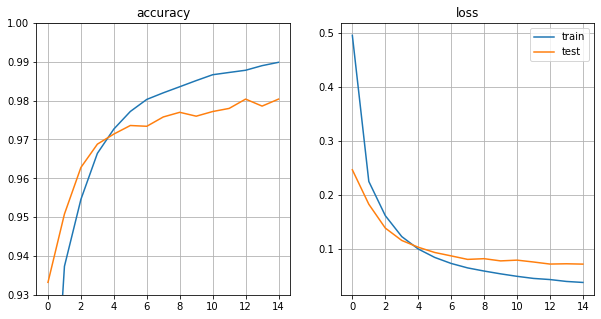

In [35]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(), 
              metrics=['accuracy'])
history = model.fit(x=x_train_2d, y=y_train, validation_data=(x_test_2d,y_test),
                    batch_size=500, epochs=15)
plot_history(history, miny=0.93)

We see that, with approximately the same number of parameters, the convolutional network is already able to beat the dense network with 100 neurons.

Here is the reason: 

In the dense network, the first layer has a lot of parameters, needed to connect to all pixels in the image. But for a given local region of the image, the numbers of available is actually not that large. So this network is not able to learn much about each region. We could increase the number of parameters, but the network would then become very complex, and therefore more subject to overfitting. 

In the convolutional network, on the other hand, the convolutional layer has a very small number of parameters related to its kernel. But it's still able to learn complex information about the whole image because the Kernel is moved across the image. 

That being said, our convolutional network is still very simple! In the next sections, we'll see how to improve it further.

## Stacked Convolutional Neural Network

Improving convolutional neural networks is a field of research. 

The most straightforward and conventional approach is just to stack convolutional layers.

For example, here is the architecture of a fairly recent convolutional network, [VGG16](https://arxiv.org/abs/1409.1556): 

![](https://github.com/cbernet/introduction_machine_learning/blob/master/notebooks/deep_learning_intro/vgg16.png?raw=1)

In the first part of the network, we see five convolutional blocks (conv1 to 5), which consist of stacked convolutional layers followed by a max pooling layer. So we'll call this part the convolutional part.

This part produces a tensor with 7x7x512 values for each image. The first two dimensions, (7,7), are aligned with the dimensions of the original image, and we can think of this as a very coarse version of the image, with only 7x7=49 large pixels. But for each pixel, instead of having 3 color channels, we have 512 features that describe what the network is seeing in this pixel.

This tensor therefore contains 7x7x512 = 25 088 numbers that are the features extracted by the network for the image.

These numbers are interpreted by a dense subnetwork with two layers, each with 4096 neurons. 

Finally, a softmax layer classifies the images in 1000 categories. 

So let us start stacking convolutional layers as well:

In [36]:
model = models.Sequential([
    layers.Conv2D(16, 3, input_shape=(28,28,1), 
                  activation='relu'),
    layers.MaxPooling2D(2), 
    layers.Conv2D(32, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(50, activation='relu'),
    layers.Dense(10, activation='softmax'), 
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
flatten_1 (Flatten)          (None, 3872)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                193650    
_________________________________________________________________
dense_8 (Dense)              (None, 10)                510       
Total params: 198,960
Trainable params: 198,960
Non-trainable params: 0
________________________________________________

In the style of VGG networks, we are now using convolutional kernels of size 3. We end up with a coarse image of 11x11 pixels. And for each pixel, we have 32 values.

Let's compile and train:

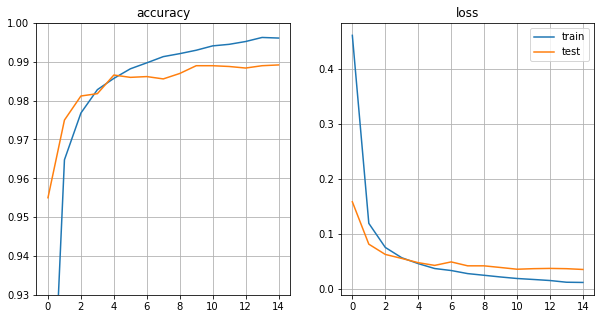

In [37]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(), 
              metrics=['accuracy'])
history = model.fit(x=x_train_2d, y=y_train, validation_data=(x_test_2d,y_test),
                    batch_size=500, epochs=15, verbose=0)
plot_history(history, miny=0.93)

We see that the training accuracy is higher than previously. That's because this network has more parameters, and is thus able to better fit the training dataset. 

And we also gain 1% on the test accuracy, which is huge at this stage. Indeed, the closer you get to 100%, the more you need to fight for a fraction of a percent. 

However, the test accuracy is lower than the training accuracy, which is a sign of overfitting. If we could do something about that, maybe we could improve the performance further. 

In the next section, we will use dropout to reduce overfitting. But first, let's redo the plot above with a zoom on the y axis:  

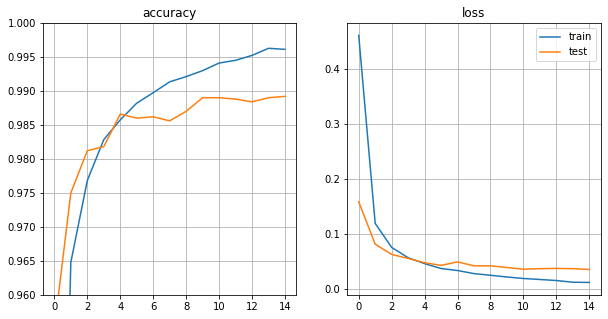

In [38]:
plot_history(history, miny=0.96)

## Taming Overfitting with Dropout

To deal with overfitting, we're going to add a dropout layer at the end of the convolutional part, just before the dense classification part. 

During the training, for each input image, the dropout layer randomly sets a fraction of its inputs to zero, and just transmits the rest as it is. For testing and evaluation, the dropout layer is removed. 

We start by setting the dropout fraction to 50%:



Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
flatten_6 (Flatten)          (None, 3872)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 3872)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 50)                193650    
_________________________________________________________________
dense_21 (Dense)             (None, 10)               

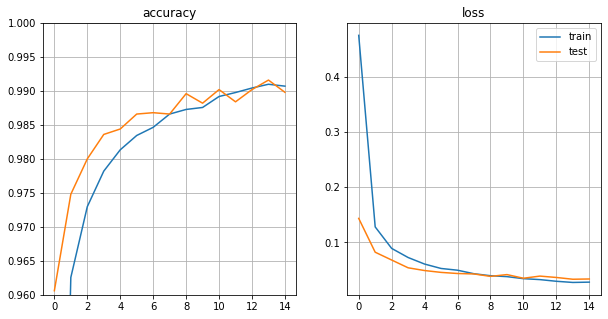

In [53]:
model = models.Sequential([
    layers.Conv2D(16, 3, input_shape=(28,28,1), 
                  activation='relu'),
    layers.MaxPooling2D(2), 
    layers.Conv2D(32, 3, activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(50, activation='relu'),
    layers.Dense(10, activation='softmax'), 
])

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(), 
              metrics=['accuracy'])

history = model.fit(x=x_train_2d, y=y_train, validation_data=(x_test_2d,y_test),
                    batch_size=500, epochs=15, verbose=0)

plot_history(history, miny=0.96)

The training and test accuracies are now much closer! but dropout makes it difficult for the network to learn, and we must train longer to reach the same level of training accuracy:

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
flatten_7 (Flatten)          (None, 3872)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 3872)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 50)                193650    
_________________________________________________________________
dense_23 (Dense)             (None, 10)              

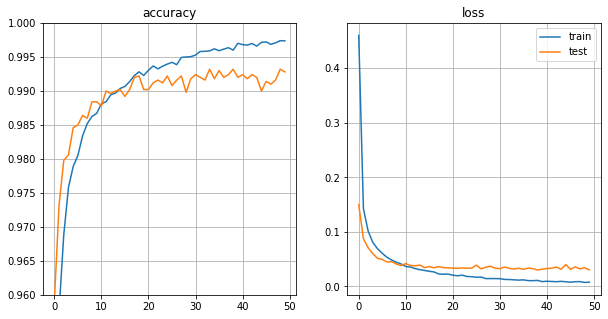

In [54]:
model = models.Sequential([
    layers.Conv2D(16, 3, input_shape=(28,28,1), 
                  activation='relu'),
    layers.MaxPooling2D(2), 
    layers.Conv2D(32, 3, activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(50, activation='relu'),
    layers.Dense(10, activation='softmax'), 
])

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(), 
              metrics=['accuracy'])

history = model.fit(x=x_train_2d, y=y_train, validation_data=(x_test_2d,y_test),
                    batch_size=500, epochs=50, verbose=0)

plot_history(history, miny=0.96)

## More dropout

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
flatten_8 (Flatten)          (None, 3872)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 3872)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 50)                193650    
_________________________________________________________________
dense_25 (Dense)             (None, 10)              

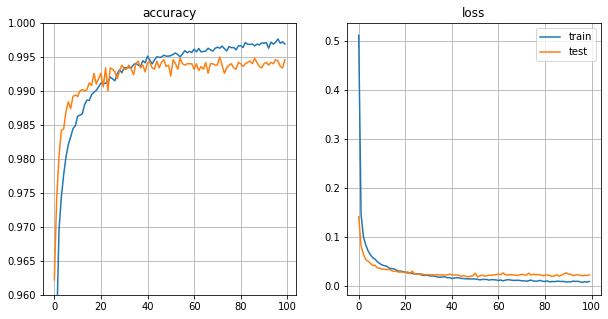

In [55]:
model = models.Sequential([
    layers.Conv2D(16, 3, input_shape=(28,28,1), 
                  activation='relu'),
    layers.MaxPooling2D(2), 
    layers.Conv2D(32, 3, activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.7),
    layers.Dense(50, activation='relu'),
    layers.Dense(10, activation='softmax'), 
])

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(), 
              metrics=['accuracy'])

history = model.fit(x=x_train_2d, y=y_train, validation_data=(x_test_2d,y_test),
                    batch_size=500, epochs=100, verbose=0)

plot_history(history, miny=0.96)

We reach a test accuracy of almost 99.5% ! 

---

**Exercise: can you beat me?**

Try and optimize the network further. You can: 

* add convolutional layers
* increase the kernel size of selected convolutional layers
* increase the number of features learned by the convolutional layers
* further increase dropout and train longer

What's the maximum test accuracy you can reach? 

---


Now remember that the test dataset contains 5 000 images. This means that only 25 images or so are misentified. In the next section, we will see how to select and display these images.

## Misidentified images

To find the misidentified images, we first need to evaluate the network for all images in the test dataset: 

In [56]:
predictions = model.predict(x_test_2d)
predictions.shape

(5000, 10)

The predictions and the true labels are one-hot encoded, as we discussed already. So for each image, we get 10 numbers, which are the estimated probabilities for the image to belong to each category. 

We find the category with highest probability:

In [57]:
pred_labels = np.argmax(predictions, axis=-1)
print(pred_labels.shape)
pred_labels

(5000,)


array([5, 0, 4, ..., 2, 1, 2])

And we do the same for the true labels: 

In [58]:
true_labels = np.argmax(y_test, axis=-1)
print(pred_labels.shape)
pred_labels

(5000,)


array([5, 0, 4, ..., 2, 1, 2])

Now, we can create a mask for the misidentified examples. We use this mask to select the misidentified images: 

In [59]:
misidentified = true_labels != pred_labels
mis_images = x_test_2d[misidentified]
mis_images.shape

(27, 28, 28, 1)

And we also select the true labels and the predicted labels for the misidentified examples:

In [60]:
mis_true = true_labels[misidentified]
mis_pred = pred_labels[misidentified]

Finally, we can plot some of the misidentified examples:

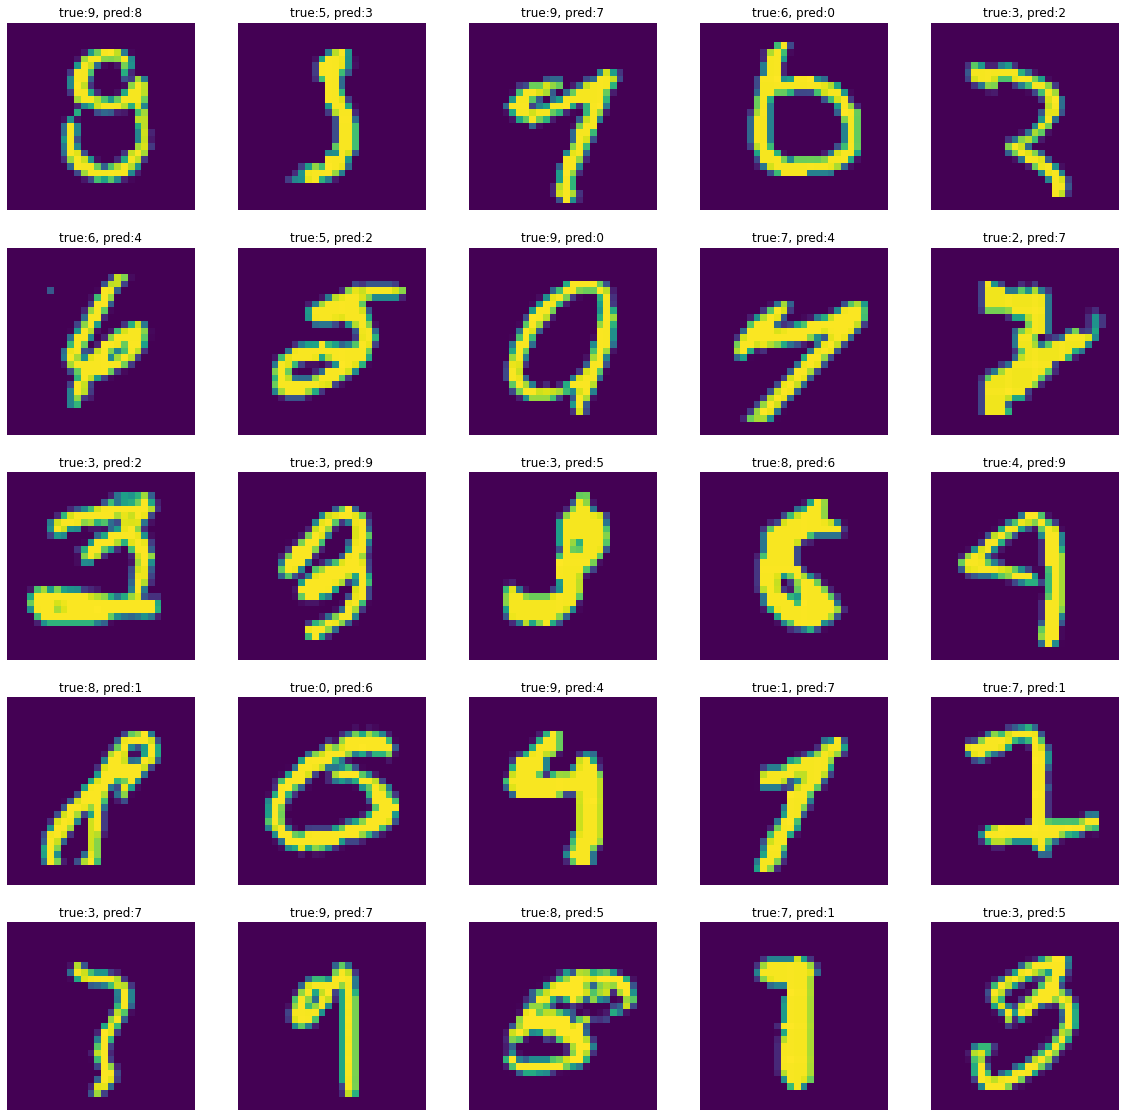

In [61]:
fig = plt.figure(figsize=(20,20))
for i in range(25):
    fig.add_subplot(5,5,i+1)
    plt.imshow(mis_images[i].reshape(28,28))
    plt.title('true:{}, pred:{}'.format(
        mis_true[i],
        mis_pred[i]
    )
    )
    plt.axis('off')

As you can see, the misidentified examples are not very obvious, even for a human. And we can really understand the choice of the network in most cases. 

Maybe people should just learn to write properly... 

## Influence of the choice of the test dataset and cross-validation

As we discussed previously, the number of misidentified images is low: 

In [62]:
mis_images.shape[0]

27

27 misidentified images gives us an accuracy of 1 - 27/5 000 = 99.46%. 

There is a given probability to get difficult images in the test dataset. The more you get, the more difficult it is for the network.

Until now, we have built the test dataset with the first 5 000 images. Let's try and take the 5 000 last images: 

In [63]:
test_size=5000
x_test_2d_2 = images[-test_size:].reshape(-1, 28, 28,1)
y_test_2 = targets[-test_size:]
x_train_2d_2 = images[:-test_size].reshape(-1, 28, 28,1)
y_train_2 = targets[:-test_size]

And we retrain the exact same network, in the same conditions: 

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 11, 11, 32)        4640      
_________________________________________________________________
flatten_9 (Flatten)          (None, 3872)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 3872)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 50)                193650    
_________________________________________________________________
dense_27 (Dense)             (None, 10)              

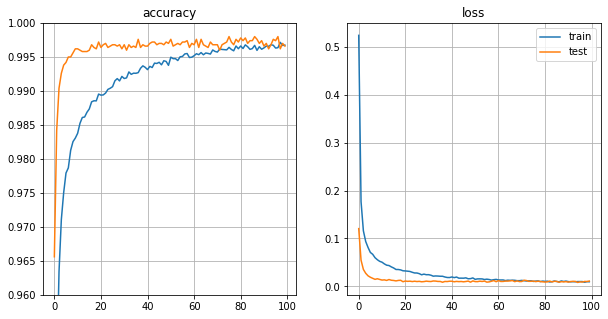

In [64]:
model = models.Sequential([
    layers.Conv2D(16, 3, input_shape=(28,28,1), 
                  activation='relu'),
    layers.MaxPooling2D(2), 
    layers.Conv2D(32, 3, activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.7),
    layers.Dense(50, activation='relu'),
    layers.Dense(10, activation='softmax'), 
])

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(), 
              metrics=['accuracy'])

history = model.fit(x=x_train_2d_2, y=y_train_2, 
                    validation_data=(x_test_2d_2, y_test_2),
                    batch_size=500, epochs=100, verbose=0)

plot_history(history, miny=0.96)

This time, the number of misidentified images is: 

In [65]:
(1-history.history['val_accuracy'][-1])*5000

17.000138759613037

The final test accuracy is higher than previously, simply because this test dataset features less difficult images.

Finally, even for a given test dataset, please note the fluctuations of the test accuracy. The parameters of the network change over time. For this reason, at a given epoch, images can get misclassified or not, hence the fluctuations. 

For instance, if we had stopped training at epoch 95, we would have estimated a different performance on *this* test dataset. But this does not really mean anything. 

One way to deal with this problem would be to increase the size of the test dataset. But since the total size of the dataset is limited, this would imply reducing the training dataset, and therefore increasing overfitting. 

Another possibility is to resort to [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)). For example, in k-fold cross-validation, the original sample is randomly partitioned into k equal sized subsamples. Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k − 1 subsamples are used as training data. The cross-validation process is then repeated k times, with each of the k subsamples used exactly once as the validation data. The k results can then be averaged to produce a single estimation. Often, people choose k=10. 